In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

sns.set(style="darkgrid")


warnings.filterwarnings('ignore')

   # Renaming the columns for training and test sets

In [7]:
def concat_df(train_data, test_data):  
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['survived'], axis=1)

train = pd.read_csv("train.csv")
train_shape = train.shape

test = pd.read_csv("test.csv")
test_shape = test.shape

train.columns = ['passengerId','survived','ticketClass','passenger_name','sex','age',
                 'number_of_sibling_or_spouse','number_of_parent_or_children', 
                 'ticketId','passenger_fare', 'cabin_number','port_of_embarkation']

test.columns = ['passengerId','ticketClass','passenger_name','sex','age',
                 'number_of_sibling_or_spouse','number_of_parent_or_children', 
                 'ticketId','passenger_fare', 'cabin_number','port_of_embarkation']

#To see correlation we keep only the features which seem more useful...
train = train[['passengerId','survived','ticketClass','passenger_name','sex','age',
                 'number_of_sibling_or_spouse','number_of_parent_or_children',
               'ticketId','passenger_fare', 'cabin_number','port_of_embarkation']]

test = test[['passengerId','ticketClass','passenger_name','sex','age',
                 'number_of_sibling_or_spouse','number_of_parent_or_children',
             'ticketId','passenger_fare', 'cabin_number','port_of_embarkation']]

df_all = concat_df(train, test)
train.name = 'Training Set'
test.name = 'Test Set'
df_all.name = 'All Set' 
dfs = [train, test]

print(df_all.dtypes)


age                             float64
cabin_number                     object
number_of_parent_or_children      int64
number_of_sibling_or_spouse       int64
passengerId                       int64
passenger_fare                  float64
passenger_name                   object
port_of_embarkation              object
sex                              object
survived                        float64
ticketClass                       int64
ticketId                         object
dtype: object


# Imputation of missing values


### Filling age missing values by taking into account the sex and the ticket class.

In [8]:
age_by_pclass_sex = df_all.groupby(['sex', 'ticketClass']).median()['age']

print('Count of missing age :',df_all['age'].isnull().sum()/len(df_all['age']))
# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['age'] = df_all.groupby(['sex', 'ticketClass'])['age'].apply(lambda x: x.fillna(x.median()))
df_all['age'] = pd.qcut(df_all['age'], 10)



Count of missing age : 0.20091673032849502


### Port of embarkation missing value
When I googled Stone, Mrs. George Nelson (Martha Evelyn), I found that she embarked from S (Southampton) with her maid Amelie Icard, in this page Martha Evelyn Stone: Titanic Survivor.

Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.

Missing values in Embarked are filled with S with this information.

In [9]:
print('Count of missing port_of_embarkation :',df_all['port_of_embarkation'].isnull().sum())
# Filling the missing values in Embarked with S
df_all['port_of_embarkation'].fillna('S', inplace=True)


Count of missing port_of_embarkation : 2


 ### Passenger fare missing value
 The passenger fare is missing only once on the test set for a person with the family name 'Storey'. 

1) So first of all, we take some information regarding the person named 'storey' who has a 'NaN' passenger fare. 
Those informations are :
- his ticket class ;
- his port of embarkation ;
- the number of parent/children;
- the number of sibling/spouse.
    
2) Afterwards, we can filter the dataframes by selecting :
- persons with the same ticket class as storey, this generate a dataframe called 'dfSameTicketClass'
- We use the latter generated dataframe 'dfSameTicketClass' to select persons with the same number of sibling/spouse, this will generated another dataframe called 'dfsameSiblSp'
- We use 'dfsameSiblSp' and select persons with the same number of parent/children as Storey
- We do the same thing with sex and port of embarkation.
    
Finally, we have a dataframe containing data regarding people who were travelling in the same situation as Storey (ticket class, port of embarkation, numbers of spouse/sibling and parent/children). We take their passenger fares and take the median to replace the missing value for Storey.
  
     

In [10]:
lineWithMissingFare = df_all[df_all['passenger_fare'].isna()] 
storeyTicketClass = lineWithMissingFare.ticketClass.values[0]
storeyPort = lineWithMissingFare.port_of_embarkation.values[0]
storeyParentCh = lineWithMissingFare.number_of_parent_or_children.values[0]
storeySiblingSp = lineWithMissingFare.number_of_sibling_or_spouse.values[0]

#We select the person with the same ticket class, number of sibling/spouse, number of parent/children, sex and port of embarkation. 
dfSameTicketClass = df_all[ df_all['ticketClass'] == storeyTicketClass ]
dfsameSiblSp = dfSameTicketClass[dfSameTicketClass['number_of_sibling_or_spouse'] == storeySiblingSp] 
dfsameParch = dfsameSiblSp[dfsameSiblSp['number_of_parent_or_children'] == storeyParentCh]
dfsameSex = dfsameParch[dfsameParch['sex'] == 'male']
dfsamePort = dfsameSex[dfsameSex['port_of_embarkation'] == storeyPort]

#We take the median of passenger fares for the passengers travelling on the same conditions as Storey.
valueToImpute = dfsamePort.passenger_fare.median()

# We replace the NaN value with the previous median 
df_all['passenger_fare'].fillna(valueToImpute, inplace=True)

nancols = [col for col in df_all.columns if df_all[col].isnull().any()]

#We cut passenger_fare into 13 buckets / groups / categories
df_all['passenger_fare'] = pd.qcut(df_all['passenger_fare'], 13)

# Feature engineering 

### Feature engineering with the 'cabin' feature
The large portion of the Cabin feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. 
It turns out to be the first letter of the Cabin values are the decks in which the cabins are located. 
Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.

<img src="image.png" />

- On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset
- A, B and C decks were only for 1st class passengers
- D and E decks were for all classes
- F and G decks were for both 2nd and 3rd class passengers
- From going A to G, distance to the staircase increases which might be a factor of survival

In [11]:
def display_missing(df): 
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['deck'] = df_all['cabin_number'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck
# Thus, Passenger in the T deck is changed to A
idx = df_all[df_all['deck'] == 'T'].index
df_all.loc[idx, 'deck'] = 'A'

df_all['deck'] = df_all['deck'].replace(['A', 'B', 'C'], 'ABC') #A, B and C decks were only for 1st class passengers
df_all['deck'] = df_all['deck'].replace(['D', 'E'], 'DE') #D and E decks were for all classes
df_all['deck'] = df_all['deck'].replace(['F', 'G'], 'FG') #F and G decks were for both 2nd and 3rd class passengers

# Dropping the Cabin feature
df_all.drop(['cabin_number'], inplace=True, axis=1)

### Creation of the family size feature


In [7]:
#the number of sibling or spouse + the number of parent or children + 1 (the person itself)
df_all['family_size'] = df_all['number_of_sibling_or_spouse']+ df_all['number_of_parent_or_children'] + 1

### Creation of the ticket frequency feature 

In [8]:
#Counting the number of occurences for each ticket id
df_all['ticket_frequency'] = df_all.groupby('ticketId')['ticketId'].transform('count')


### Creation of the 'is married' feature 

In [9]:
 #if 'Mrs' is found on the passenger name, we can conclude that the person is married 
df_all['title'] = df_all['passenger_name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['is_married'] = 0
df_all['is_married'].loc[df_all['title'] == 'Mrs'] = 1


df_all['title'] = df_all['title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['title'] = df_all['title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy') 

### Creation of the 'family_name' feature 
'extract_surname' function is used for extracting surnames of passengers from the Name feature. Family feature is created with the extracted surname. This is necessary for grouping passengers in the same family.

In [10]:
def extract_surname(data):    
    families = []
    for i in range(len(data)):        
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        families.append(family)
    return families

df_all['family_name'] = extract_surname(df_all['passenger_name'])
df_train = df_all.loc[:890]
df_test= df_all.loc[891:]
dfs = [df_train, df_test]

### Survival rates
Family_Survival_Rate is calculated from families in training set since there is no Survived feature in test set. A list of family names that are occuring in both training and test set (non_unique_families), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in Family_Survival_Rate feature.

An extra binary feature Family_Survival_Rate_NA is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

Ticket_Survival_Rate and Ticket_Survival_Rate_NA features are also created with the same method. 

Ticket_Survival_Rate and Family_Survival_Rate are averaged and become Survival_Rate, and Ticket_Survival_Rate_NA and Family_Survival_Rate_NA are also averaged and become Survival_Rate_NA.

In [11]:

# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['family_name'].unique() if x in df_test['family_name'].unique()]
non_unique_tickets = [x for x in df_train['ticketId'].unique() if x in df_test['ticketId'].unique()]
 
df_family_survival_rate = df_train.groupby('family_name')['survived', 'family_name','family_size'].median()
df_ticket_survival_rate = df_train.groupby('ticketId')['survived', 'ticketId','ticket_frequency'].median()


family_rates = {}
ticket_rates = {}
for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]
    
     

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]
        
        
        

In [12]:

mean_survival_rate = np.mean(df_train['survived'])
train_family_survival_rate = []
train_family_survival_rate_NA = []

test_family_survival_rate = []
test_family_survival_rate_NA = []


# The survival rate is calculated for families with more than 1 members in that list, and stored in Family_Survival_Rate feature. 
for i in range(len(df_train)):
    if df_train['family_name'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['family_name'][i]])
        train_family_survival_rate_NA.append(1)
   # An extra binary feature Family_Survival_Rate_NA is created for families that are unique to the test set.
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
# We do the same for the test set. 
for i in range(len(df_test)):
    if df_test['family_name'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['family_name'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
                
df_train['family_survival_rate'] = train_family_survival_rate
df_train['family_survival_rate_na'] = train_family_survival_rate_NA

df_test['family_survival_rate'] = test_family_survival_rate
df_test['family_survival_rate_na'] = test_family_survival_rate_NA

 #### We do the same process we did for family survival rate above, for the ticket id survival rate 

In [13]:
train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['ticketId'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['ticketId'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)

        
for i in range(len(df_test)):
    if df_test['ticketId'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['ticketId'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['ticket_survival_rate'] = train_ticket_survival_rate
df_train['ticket_survival_rate_na'] = train_ticket_survival_rate_NA
df_test['ticket_survival_rate'] = test_ticket_survival_rate
df_test['ticket_survival_rate_na'] = test_ticket_survival_rate_NA

   
    


#### Averaging the ticket survival rate and the family survival rate to crate a new feature called survival rate
(we do the same for 'survival_rate_na)


In [14]:
for df in [df_train, df_test]:
    df['survival_rate'] = (df['ticket_survival_rate'] + df['family_survival_rate']) / 2
    df['survival_rate_na'] = (df['ticket_survival_rate_na'] + df['family_survival_rate_na']) / 2 

# Feature encoding : Dummy variables
Types before encoding : 
- age (category)
- passenger_fare (category)
- port_of_embarkation (object)
- sex (object)
- deck (object)
- title (object)

In [15]:
def createDummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

df_train = createDummies(df_train,"age")
df_test = createDummies(df_test,"age")

df_train = createDummies(df_train,"passenger_fare")
df_test = createDummies(df_test,"passenger_fare")

df_train = createDummies(df_train,"port_of_embarkation")
df_test = createDummies(df_test,"port_of_embarkation")

df_train = createDummies(df_train,"sex")
df_test = createDummies(df_test,"sex")


df_train = createDummies(df_train,"deck")
df_test = createDummies(df_test,"deck")

df_train = createDummies(df_train,"title")
df_test = createDummies(df_test,"title")

#### Deletion of useless features

In [16]:
df_train.drop( columns = ['passenger_name','ticketId','family_name','age','passenger_fare','title',
                         "age","port_of_embarkation","sex","deck",'number_of_parent_or_children',
                          'number_of_sibling_or_spouse'],inplace = True)

df_test.drop( columns = ['passenger_name','ticketId','family_name','age','passenger_fare','title',
                         "age","port_of_embarkation","sex","deck",'number_of_parent_or_children',
                          'number_of_sibling_or_spouse'],inplace = True)

# Optimization & Model Selection
Algorithm tuning is a final step in the process of applied machine learning before presenting results.
Machine learning models are parameterized so that their behavior can be tuned for a given problem.

Models can have many hyperparameters and finding the best combination of hyperparameters can be treated as a search problem.
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes.

A search consists of:
- an estimator (regressor or classifier such as sklearn.svm.SVC());
- parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme;
- a score function. 


 Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid (here 'hyperparam_grid'). The best combination of hyperparameters (i.e the combination with the most high cross validation score) is retained.
 
Here we will compare the performance (accuracy) of 3 differents algorithms : Random Forest, Logistic Regression and SVC
for a binary classification. The best model with its best hyperparameter cofiguration will be selected as the final model.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#Lasso and Ridge regularization techniques
penalty = ['l1', 'l2']

#C is the inverse of the regularization term (1/lambda). 
#It tells the model how much large parameters are penalized
#Smaller values result in larger penalization; must be a positive float.
C = [0.1, 1, 10] 

#Allows you to place greater emphasis on a specific class
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}] 
solver = ['liblinear', 'saga']

hyperparam_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)


pipeline = Pipeline([('classifier', RandomForestClassifier())])

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': C,
                 'classifier__class_weight': class_weight,
                'classifier__solver': ['liblinear', 'saga']},
                
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 1000],
                 'classifier__class_weight': class_weight},
               
               {'classifier': [SVC()],
                 'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                 'classifier__C': C,
                 'classifier__class_weight': class_weight,
                'classifier__gamma': ['scale', 'auto']},]

grid = GridSearchCV(estimator=pipeline, #Estimator or model used
                    param_grid=search_space, #Parameter space
                    scoring='roc_auc', #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) to evaluate the predictions on the test set
                    verbose=1, #Controls the verbosity: the higher, the more messages
                    cv = 10, #Number of folds for the Cross Validation process
                    n_jobs=-1) 


best_model = grid.fit(df_train, df_train['survived'])

print('Best Score: ', best_model.best_score_)
print('Best Params: ', best_model.best_params_)

Fitting 10 folds for each of 117 candidates, totalling 1170 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed: 24.5min


Best Score:  1.0
Best Params:  {'classifier': LogisticRegression(C=0.1, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 0.1, 'classifier__class_weight': {1: 0.5, 0: 0.5}, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 1170 out of 1170 | elapsed: 24.5min finished


# Feature correlation with target 'survived'

In [18]:
def getListOfColumnAndCorr(dataframe, correlations_df):
    res = []
    for i in range(len(dataframe.columns)):
        res.append([dataframe.columns[i],correlations_df[i]])
    return res 

# returns the n more correlated (with the target) features 
def getNMoreCorrelatedFeatures(n,columnsAndCorrelations):
    sortedList = columnsAndCorrelations.sort(key = lambda x: abs(x[1]), reverse = True)
    return [columnsAndCorrelations[i][0] for i in range(1,n) ]



pearson_correlations = df_train.corrwith(method='pearson',other = train['survived'])
columns_correlations = getListOfColumnAndCorr(df_train,pearson_correlations)

# Feature Selection
We will select different numbers of features for prediction and try to find out how much features we need to have the more accurate predictions for the final model.

The curve below tells us that ' 45 ' is the number of features we should use to have the highest accuracy  0.8192883895131086 .


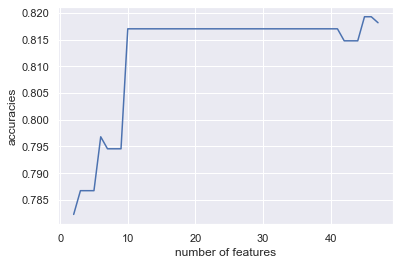

In [19]:
from sklearn.model_selection import cross_val_score

#returns the number of more correlated features selected which gave the best accuracy
def getNumberOfFeaturesWithBestScore(numberOfFeatures,accuracies):
    return numberOfFeatures[accuracies.index(max(accuracies))]
    
accuracies = []
number_of_features = []
training_y = df_train['survived']

#we try each number between 2 and the max number of features to select how much feature we need
#and we select the n more correlated features with the target feature.
for i in range(2,len(columns_correlations)):
    features = getNMoreCorrelatedFeatures(i,columns_correlations)
    training_xs = df_train[features]
    lr = best_model.best_params_["classifier"]
    # train a logistic regression model on the i more correlated features with cross validation
    scores = cross_val_score(lr, training_xs, training_y, cv=10)
    
    #we add the accuracy obtained and the number of feature we selected to obtain this accuracy
    accuracies.append(np.mean(scores))
    number_of_features.append(i)

df_to_plot = pd.DataFrame(list(zip(number_of_features, accuracies)),columns=['number of features','accuracies'])
sns.lineplot(x = 'number of features', y = 'accuracies', data = df_to_plot)


holdout = df_test
best_number_of_features = getNumberOfFeaturesWithBestScore(number_of_features,accuracies)
features = getNMoreCorrelatedFeatures(best_number_of_features,columns_correlations)
print("The curve below tells us that '", best_number_of_features,
      "' is the number of features we should use to have the highest accuracy ",
      max(accuracies),'.')


# Training

#### We use the best model with its best hyperparameter configuration as the final model to train and make predictions.

In [20]:
classifier = best_model.best_params_["classifier"]
all_X = df_train[features]
all_y = df_train['survived']
cross_validation_scores = []

#This cross-validation object is a variation of KFold that returns stratified folds. 
#The folds are made by preserving the percentage of samples for each class.
stratified_Kfold = StratifiedKFold(n_splits=10)

#Cross validation process to train the model on all the data available
for train_index, test_index in stratified_Kfold.split(all_X, all_y):
    X_train, X_test = all_X.iloc[train_index], all_X.iloc[test_index]
    y_train, y_test = all_y.iloc[train_index], all_y.iloc[test_index]
    model = classifier.fit(X_train, y_train)
    cross_validation_scores.append(model.score(X_test,y_test))

# Evaluation

#### Checking the AUC score 

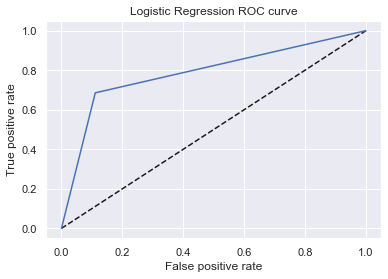

AUC SCORE 0.7873015873015873


In [21]:
predictions = classifier.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictions)

plt.plot([0,1], [0,1], 'k--')
plt.plot(false_positive_rate,true_positive_rate, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("Logistic Regression ROC curve")
plt.show()

print('AUC SCORE', auc(false_positive_rate,true_positive_rate))


# Creation of the submission file
#### used for the kaggle challenge

In [95]:

holdout_predictions = classifier.predict(holdout[features]).astype(int)
holdout_passenger_ids = holdout["passengerId"]
submission_df = {"PassengerId": holdout_passenger_ids,
                 "Survived": holdout_predictions}

submission = pd.DataFrame(submission_df)

submission.to_csv('titanic_submission.csv', index=False)